# Postie Data Challenge

#### Results from William Hayes

After connecting to [your s3 bucket](https://s3.console.aws.amazon.com/s3/buckets/postie-testing-assets/), I downloaded each of the three CSV files onto my local and created a folder for the analysis. Then I used Anaconda to create a virtual environment (venv) for this challenge. Venvs are useful for tracking and isolating exactly which packages are used in a given project. This is especially useful when constructing ML pipelines, building python packages, or deploying to a platform as a service (PaaS) such as Heroku or Streamlit.

> conda create -n postie python=3.9

Then I installed the packages I would need.

> pip install pandas

> pip install matplotlib

> pip install mlxtend 

> pip install scipy

> pip install statsmodels

> pip install sklearn

Which are all available in the requirements.txt file generated using the command

> pip freeze > requirements.txt

### 0) Data Pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import the data from each of the three CSV files. 
# Since we have unique identifiers of website_id and customer_id, 
# we will import those as strings to preserve any potential leading zeroes
dtypes = {' website_id': str, ' customer_id': str}
july_1 = pd.read_csv('./data/2017-07-01.csv', dtype=dtypes)
july_2 = pd.read_csv('./data/2017-07-02.csv', dtype=dtypes)
july_3 = pd.read_csv('./data/2017-07-03.csv', dtype=dtypes)

# Combine the data to analyze one composite dataframe
sales = pd.concat([july_1, july_2, july_3]).reset_index(drop=True)

# Most of the column headers have a space in front of their names which
# needs to be removed
new_col_names = [header.strip() for header in sales.columns]
sales.columns = new_col_names

# The timestamp needs to be converted to a datetime object.
# Since the timestamp format indicates UTC time, we will set the
# utc parameter to "True". Then, sort the data as a series of
# chronological events and reset the index. I also like to add
# date and time columns to my dataframe to make certain analyses easier.
sales['timestamp'] = pd.to_datetime(sales['timestamp'], utc=True)
sales.sort_values('timestamp', inplace=True)
sales.reset_index(drop=True, inplace=True)
sales['date'] = sales['timestamp'].dt.date
sales['time'] = sales['timestamp'].dt.time

# Re-order the columns to make viewing them easier
column_order = ['timestamp','date', 'time', 'website_id', 'customer_id', 
                'app_version', 'placeholder', 'checkout_amount', 'url']
sales = sales[column_order]

# Take a high-level view of the data. The standard deviation 
# of the checkout amount is very high relative to the mean which
# tells me that there are likely only a few transactions accounting for
# the bulk of the checkout value. I will investigate these in the next cell
sales.describe(include='all')

C:\Users\William\AppData\Local\Temp\ipykernel_29116\2957570456.py:41: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  sales.describe(include='all')


,timestamp,date,time,website_id,customer_id,app_version,placeholder,checkout_amount,url
count,33188,33188,33188,33188,33188,33188.000000,8189,33188.000000,33188
unique,31137,3,27539,2,11612,NaN,1,NaN,1964
top,2017-07-02 15:44:59+00:00,2017-07-03,22:52:53,124,9418,NaN,new_version,NaN,http://xyz.com/checkout?Natal+Orange=1
freq,4,11748,5,16631,4,NaN,8189,NaN,1499
first,2017-07-01 00:00:15+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2017-07-03 23:59:57+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,1.124675,NaN,17.742859,NaN
std,NaN,NaN,NaN,NaN,NaN,0.043112,NaN,626.783801,NaN
min,NaN,NaN,NaN,NaN,NaN,1.100000,NaN,-12.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,1.100000,NaN,5.000000,NaN


In [2]:
# The url of the highest sales amount contains a string that
# says "error". The url also tells me that the customer only 
# ordered 1 bignay, which likely means that this row represents
# some kind of system error and not $60k in sales.
sales.sort_values('checkout_amount', ascending=False).head()

,timestamp,date,time,website_id,customer_id,app_version,placeholder,checkout_amount,url
25418,2017-07-03 07:59:32+00:00,2017-07-03,07:59:32,124,8553,1.2,new_version,60000.0,http://xyz.com/checkout?Bignay=1&error=True
5385,2017-07-01 14:33:54+00:00,2017-07-01,14:33:54,123,11613,1.1,NaN,55084.0,http://www.example.com/store/?Hazelnut=1015&Um...
4419,2017-07-01 12:44:11+00:00,2017-07-01,12:44:11,123,11613,1.1,NaN,55031.0,http://www.example.com/store/?Hazelnut=995&Ume...
16181,2017-07-02 13:02:41+00:00,2017-07-02,13:02:41,123,11613,1.1,NaN,55002.0,http://www.example.com/store/?Hazelnut=986&Ume...
22288,2017-07-03 01:44:26+00:00,2017-07-03,01:44:26,123,11612,1.1,NaN,8326.0,http://www.example.com/store/?Hazelnut=167&Ume...


In [3]:
# There are also multiple transactions that are less than or equal to zero.
# We will only look at 5 of these transactions. It doesn't look like the URL
# indicates that these are the result of an error.
negative_checkouts = sales[sales['checkout_amount'] <= 0].copy()
print(f"Number of transactions with checkout amounts <= 0: {len(negative_checkouts)}")
print(f"Total value of transactions with checkout amounts <= 0: {negative_checkouts.checkout_amount.sum()}")
sales.sort_values('checkout_amount', ascending=False).tail()

Number of transactions with checkout amounts <= 0: 21
Total value of transactions with checkout amounts <= 0: -204.0


,timestamp,date,time,website_id,customer_id,app_version,placeholder,checkout_amount,url
24222,2017-07-03 05:36:29+00:00,2017-07-03,05:36:29,124,10064,1.2,new_version,-12.0,http://xyz.com/checkout?Bignay=2
27603,2017-07-03 12:33:22+00:00,2017-07-03,12:33:22,124,10921,1.2,new_version,-12.0,http://xyz.com/checkout?Bignay=2
24005,2017-07-03 05:10:47+00:00,2017-07-03,05:10:47,123,10462,1.2,new_version,-12.0,http://store.example.com/?Hazelnut=1&Mabolo=1
25336,2017-07-03 07:49:50+00:00,2017-07-03,07:49:50,124,10998,1.2,new_version,-12.0,http://xyz.com/checkout?European+Grape=1&Round...
28754,2017-07-03 14:57:28+00:00,2017-07-03,14:57:28,123,10177,1.2,new_version,-12.0,http://store.example.com/?Round+Kumquat=1&Blac...


In [4]:
# I will consider a valid sale any sale where the checkout amount
# is greater than 0 and the url does not contain the "error" string.
# These are the sales I will consider for the analysis.
valid_sales = sales[(sales['checkout_amount'] > 0) & (~sales.url.str.contains('error'))].copy()

### Question 1
Figure out why July 3rd sales are so much lower than July 2nd sales

### Answer 1
- Just three customers (customer IDs 11611, 11612, and 11613) make up ~40% of the total value in purchases over the 3 day time window. 
- The reason that total sales were so much lower on July 3rd than they were on July 2nd is because the two highest-value customers (11613 and 11611) shopped on July 2nd and not on July 3rd. 
- Their shopping spree on July 2nd accounted for $71,496 in sales on that day (~40% of total value generated on July 2nd).

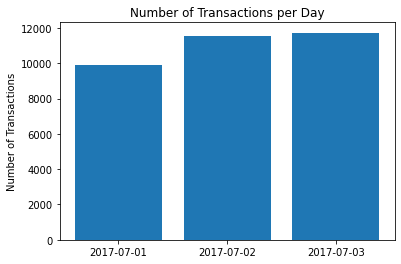

In [5]:
# There were roughly the same number of sales on July 2nd and July 3rd,
# so it isn't likely that there was a drop-off of customers causing the 
# significant difference in sales between those days
sales_per_day = valid_sales[['date', 'checkout_amount']].groupby('date').count()
sales_per_day.columns = ['num_sales']

plt.bar([str(day) for day in sales_per_day.index], sales_per_day.num_sales)
plt.title('Number of Transactions per Day')
plt.ylabel('Number of Transactions');

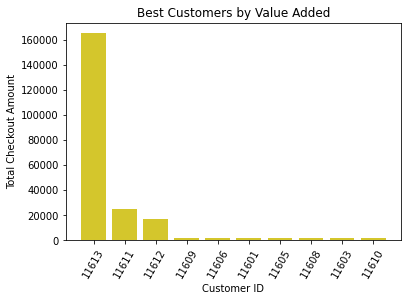

In [6]:
# The high standard deviation relative to the mean in the checkout_amount indicates that 
# the value generated for these websites is skewed towards just a few customers.
# Below are our top 10 customers by sales. 
top_10_customers = (valid_sales.groupby('customer_id')
                               .sum()
                               .sort_values('checkout_amount', ascending=False)
                               .head(10))[['checkout_amount']]

# Select a color to indicate typical customers and best customers 
# for graphs for this analysis. Blue will represent neutral metrics.
bc_color = "#D4C62C" # best customers
tc_color = "#60487D" # typical customers

plt.bar(top_10_customers.index, top_10_customers.checkout_amount, color=bc_color)
plt.title('Best Customers by Value Added')
plt.xticks(rotation=60)
plt.xlabel('Customer ID')
plt.ylabel('Total Checkout Amount');

In [7]:
# Our best customers (ids 11611, 11612, and 11613) purchase 
# orders of magnitude more in sales than other customers. 
# In fact, they make up ~40% of the total value generated 
# across this entire dataset
best_customers = top_10_customers.head(3).copy()
best_customer_value_pct = best_customers.checkout_amount.sum() / valid_sales.checkout_amount.sum()
print(f"Percent of value generated by best 3 customers: {round(best_customer_value_pct*100, 2)}%")

Percent of value generated by best 3 customers: 39.01%


In [8]:
# On July 2nd, customers 11611 and 11613 made significant purchases
july_second_sales = valid_sales[valid_sales['date'].astype(str) == '2017-07-02'].copy()
july_second_best_customer_sales = july_second_sales[july_second_sales['customer_id'].isin(best_customers.index)]
july_second_best_customer_sales_pct = july_second_best_customer_sales.checkout_amount.sum() / july_second_sales.checkout_amount.sum()

print(f"Best Customer Sales Value for July 2nd: ${july_second_best_customer_sales.checkout_amount.sum():,}")
print(f"Best Customer Sales as Percentage of Total Sales on July 2nd: {round(july_second_best_customer_sales_pct*100, 2)}%")

july_second_best_customer_sales

Best Customer Sales Value for July 2nd: $71,496.0
Best Customer Sales as Percentage of Total Sales on July 2nd: 38.91%


,timestamp,date,time,website_id,customer_id,app_version,placeholder,checkout_amount,url
14190,2017-07-02 08:57:09+00:00,2017-07-02,08:57:09,123,11611,1.1,NaN,8262.0,http://www.example.com/store/?Hazelnut=163&Ume...
15637,2017-07-02 11:50:23+00:00,2017-07-02,11:50:23,123,11611,1.1,NaN,8232.0,http://www.example.com/store/?Hazelnut=147&Ume...
16181,2017-07-02 13:02:41+00:00,2017-07-02,13:02:41,123,11613,1.1,NaN,55002.0,http://www.example.com/store/?Hazelnut=986&Ume...


In [9]:
# On July 3rd, only one of our 3 best customers (customer 11612) made a purchase. 
# Customers 11611 and 11613 did not make any purchases on July 3rd.
# This is why sales were significantly lower on July 3rd than on July 2nd.
july_third_sales = valid_sales[valid_sales['date'].astype(str) == '2017-07-03'].copy()
july_third_sales[july_third_sales['customer_id'].isin(best_customers.index)]

,timestamp,date,time,website_id,customer_id,app_version,placeholder,checkout_amount,url
22288,2017-07-03 01:44:26+00:00,2017-07-03,01:44:26,123,11612,1.1,NaN,8326.0,http://www.example.com/store/?Hazelnut=167&Ume...


### Question 2
Decide whether the average sales value per day is the right metric to use. Explain why or why not. Then, determine any other metrics they should be using.

### Answer 2
As we saw in Answer 1, a few customers generate a disproportionate value of sales. Since the average is highly sensitive to outlier spenders like customers 11611, 11612, and 11613 it is likely not the best metric to determine the success of a business day. For instance, the spending habits of 11611 and 11613 alone brought the average sales value from $9.73 to $15.93 per transaction. If the decision-maker is interested in knowing what the typical transaction amount might be, the median checkout amount (much more resistant to outliers) will provide a much closer idea of the expected transaction value generated. The median checkout amount for a customer is $6, meaning that half of the transactions are purchases more than $6 and half of the transactions are purchases less than $6. Another metric worth tracking would be the number of transactions that occurred per day (stored as the sales_per_day dataframe variable). 

If the data set consisting of these three days in July is indicative of the general trend of the business, key metrics might include:
- Who is considered a top customer
- How many high-value customers the site can attract in a day
- Whether a top customer made a purchase (or visited the site)
- Top 10 transactions of the day by checkout amount by customer

Additional information that could be analyzed would be
- Finding out product preferences / purchasing habits of top customers
- Finding out if the interests of top customers are alligned to the interests of the typical customer (i.e, does everybody want hazelnut or just our top customers?)

This information will be analyzed in the next question (Question 4).

In [10]:
# Get the number of sales with and without the contribution of 
# our best customers
num_sales_july_second, = sales_per_day.iloc[1].values
num_sales_july_second_excluding_best = num_sales_july_second - len(july_second_best_customer_sales)

# Get the sales value with and without the contribution of the best customers
july_second_total_sales_value = july_second_sales.checkout_amount.sum()
best_customer_value_added = july_second_best_customer_sales.checkout_amount.sum()
july_second_total_sales_excluding_best = july_second_total_sales_value - best_customer_value_added 

print(f"Average sale value including best customers: ${round(july_second_total_sales_value / num_sales_july_second, 2)}")
print(f"Average sale value excluding best customers: $ {round(july_second_total_sales_excluding_best / num_sales_july_second_excluding_best, 2)}")

Average sale value including best customers: $15.93
Average sale value excluding best customers: $ 9.73


In [11]:
# Display the median checkout amount (what the typical transaction amount will be)
print(f"Median checkout amount: {july_second_sales.checkout_amount.median()}")

Median checkout amount: 6.0


### Question 3
Extract as much information as you can from the URLs. See if all product prices can be inferred. Determine any other information that would be useful to find out what is going on.

### Answer 3
Most of the important product information can be inferred from the urls (specifically the product type and quantity purchased). Individual product prices can be solved for using a system of linear equations. As mentioned earlier, the URL indicating an error was an incredibly useful tool for making sure we did not include that outlier in our solution. There is some additional information that I would find useful. There are some transactions in this dataset with values that do not make sense to me. Specifically, 
- There are 21 transactions with a checkout amount less than or equal to 0. I am not sure what this means. I assume these values indicate giveaways or returns, but they could just as likely indicate expired, damaged, or stolen products.
- Additionally, I would like to know what caused the error that occured when customer 8553 purchased bingay. It seems like this may have been an error encountered when xyz.com rolled out their new version into production. 


Other valuable information:
- Whether the product was on sale
- Whether the product was purchased through an affiliate link from an ad campaign
- When the product entered the store / stock

In [12]:
from urllib.parse import unquote

# Different domains might have had different formats for storing their product information.
# (Thankfully they did not, but it did indicate that the new version of example.com uses
# the url of store.example.com). First, we will extract the domain name from the url
# https://stackoverflow.com/questions/36028932/how-to-extract-specific-content-in-a-pandas-dataframe-with-a-regex
sales['domain'] = sales['url'].str.split('/').str[2].str.strip()

# Extract product information from the different urls
sales['products'] = sales['url'].str.split('?').str[-1].str.strip()
sales['products'] = sales['products'].str.replace('+','_', regex=False).str.lower()
# This will replace URL encodings with raw strings (Specifically for '%2F' to '/')
sales['products'] = sales['products'].apply(lambda product: unquote(product))

# This function creates a dictionary that associates the 
# product purchased with the quantity of that product purchased.
def extract_order_info(product_string):
    product_list = product_string.split('&')
    product_quantities = {}
    for product in product_list:
        product_name, quantity = product.split('=')
        product_quantities[product_name] = quantity
    return product_quantities

# Flatten the product data from the URL to associate the item purchased
# with the quantity of items purchased.
# Accomplished wrt https://stackoverflow.com/questions/45872495/turn-series-of-dictionaries-into-a-dataframe-pandas
different_products = sales['products'].apply(lambda product: extract_order_info(product))
products_df = pd.DataFrame(different_products.tolist())
# Remove the "error" product (the $60k bignay)
products_df.drop('error', axis=1, inplace=True)
# Convert number of purchases to a float
products_df = products_df.astype(float)

# Combine product information with order information
product_sales = pd.concat([sales, products_df], axis=1)

product_sales

,timestamp,date,time,website_id,customer_id,app_version,placeholder,checkout_amount,url,domain,...,natal_orange,hazelnut,round_kumquat,ylang-ylang,bignay,black/white_pepper,mabolo,ume,european_grape,prairie_potato
0,2017-07-01 00:00:15+00:00,2017-07-01,00:00:15,124,8272,1.1,NaN,6.0,http://xyz.com/checkout?Natal+Orange=1,xyz.com,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-07-01 00:00:18+00:00,2017-07-01,00:00:18,123,6921,1.1,NaN,6.0,http://www.example.com/store/?Natal+Orange=1,www.example.com,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-07-01 00:00:19+00:00,2017-07-01,00:00:19,124,9219,1.1,NaN,4.0,http://xyz.com/checkout?Hazelnut=1,xyz.com,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-07-01 00:00:28+00:00,2017-07-01,00:00:28,124,8451,1.1,NaN,7.0,http://xyz.com/checkout?Round+Kumquat=1,xyz.com,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-07-01 00:00:32+00:00,2017-07-01,00:00:32,124,6079,1.1,NaN,5.0,http://xyz.com/checkout?Ylang-ylang=1,xyz.com,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33183,2017-07-03 23:59:34+00:00,2017-07-03,23:59:34,124,8204,1.2,new_version,6.0,http://xyz.com/checkout?Ume=1,xyz.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
33184,2017-07-03 23:59:35+00:00,2017-07-03,23:59:35,124,7043,1.2,new_version,5.0,http://xyz.com/checkout?Black%2FWhite+Pepper=1,xyz.com,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
33185,2017-07-03 23:59:38+00:00,2017-07-03,23:59:38,123,7300,1.2,new_version,6.0,http://store.example.com/?Ume=1,store.example.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
33186,2017-07-03 23:59:38+00:00,2017-07-03,23:59:38,124,10245,1.2,new_version,14.0,http://xyz.com/checkout?Ume=1&Mabolo=1,xyz.com,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN


#### Find product prices by solving a system of linear equations

In [13]:
# Accomplished wrt
# https://pythonnumericalmethods.berkeley.edu/notebooks/chapter14.05-Solve-Systems-of-Linear-Equations-in-Python.html
# 
# I will solve a system of linear equations to find product prices. There are a lot
# of different ways to do this, but I think the easiest way with this
# dataset is to select 10 transactions where a customer purchased at 
# least one of each item. This way, we have 10 equations and 10 unknowns.
one_of_each = product_sales.dropna(thresh=len(product_sales.columns)).tail(10)
product_variables = one_of_each.iloc[:, 11:21].fillna(0).values
product_prices = one_of_each['checkout_amount'].values

# Use numpy to solve the system of 10 equations and 10 unknowns
prices = np.linalg.solve(product_variables, product_prices)

# Combine information about products and their prices to create
# a reference table. There was a floating point rounding error 
# causing prices such as 5.9999999999999964, so I rounded to the nearest
# 2 decimal places using list comprehension.
product_names  =  one_of_each.columns[11:21]
rounded_prices = [round(price, 2) for price in prices]
product_prices = dict(zip(product_names, rounded_prices))
product_prices

{'natal_orange': 6.0,
 'hazelnut': 4.0,
 'round_kumquat': 7.0,
 'ylang-ylang': 5.0,
 'bignay': 6.0,
 'black/white_pepper': 5.0,
 'mabolo': 8.0,
 'ume': 6.0,
 'european_grape': 5.0,
 'prairie_potato': 3.0}

In [14]:
# Validate that these prices are correct for all transactions
validation_columns = ['natal_orange', 'hazelnut', 'round_kumquat', 'ylang-ylang', 'bignay',
                      'black/white_pepper', 'mabolo', 'ume', 'european_grape',
                      'prairie_potato','checkout_amount']
product_price_validation = product_sales[validation_columns].copy()

# Use a dot product between the price values for each item and the
# quantity of items purchased to calculate the expected total checkout amount
test = product_price_validation.iloc[:, :-1].copy()
test['calculated'] = np.dot(test.fillna(0).values, prices)
test['checkout_amount'] = product_price_validation['checkout_amount']

# NOTE - it is important to round the values here due to the floating point
# error mentioned earlier. If we do not round these values, we will encounter 
# an instance where 6.0 != 6.0. This is because one of those 6.0 values is actually 
# 5.9999999997 in disguise.
# 
# Below are the transactions where our prices do NOT allign with the checkout amount.
# These are the 22 invalid transactions (21 sales <= 0 and 1 bignay error) that were 
# accounted for at the beginning of this analysis. 
test[round(test['calculated'],2) != round(test['checkout_amount'],2)]

,natal_orange,hazelnut,round_kumquat,ylang-ylang,bignay,black/white_pepper,mabolo,ume,european_grape,prairie_potato,calculated,checkout_amount
52,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0
65,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0
21551,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0
21668,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,12.0,-12.0
22151,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,12.0,-12.0
22982,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,12.0,-12.0
23709,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,12.0,-12.0
24005,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,12.0,-12.0
24108,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,12.0,-12.0
24222,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,12.0,-12.0


### Question 4
Determine any interesting purchasing combinations, events, or metrics that are worth
reporting and displaying. Then determine what information would be most relevant to the analyst.

#### Answer 4
First, I determined what quantities of products were being purchased. Then, I used the apriori algorithm to find items that were frequently purchased together. Then, I analyzed what time purchases were most likely to occur. Primary takeaways for the analyst are listed below.
- ***ANALYST***: The lowest value transactions occur at 8 am followed by the highest value transactions which occur at 9 am.
- ***ANALYST***: A customer who purchases one item is no more likely to purchase another particular item. For instance, customers who purchase ume are then just as likely to purchase hazelnut as they are mabolo. This would be in contrast to items that might be frequently purchased together in other stores (such as bread and butter, if a customer purchases bread they are also much more likely to purchase butter).
- ***ANALYST***: The typical customer shops in the morning at around 9:00 am. The best customers do their shopping around noon/afternoon. Very few people purchase items from 12 am - 6 am. The fewer people that do purchase items at this time make higher-value purchases.


Other Notes:
- Customers seem to enjoy the variety of products at these stores. Each product has a roughly equal chance of being purchased by any given customer and there is no strong preference for one product over another. 
- While the item preference of our best customers differ slightly from the item preference of the typical customer, the fact that all customers have a relatively equal liklihood of purchasing any given product means that the store owners do not need to worry about prioritizing the needs of one customer over another. I.e - If everyone loves umes then purchasing more umes will be good for all customers, not just the best customers.
- Both websites changed app versions from 1.1 to 1.2 at almost exactly the same time, July 3rd, 03:42 am. Four hours later at 07:59:32 am a customer on the new version of xyz.com encountered the $60k bignay error. This leads me to believe the error was caused by a bug in the new app version

C:\Users\William\AppData\Local\Temp\ipykernel_29116\59754301.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  best_customer_spending_habits['total'] = best_customer_spending_habits.sum(axis=1)


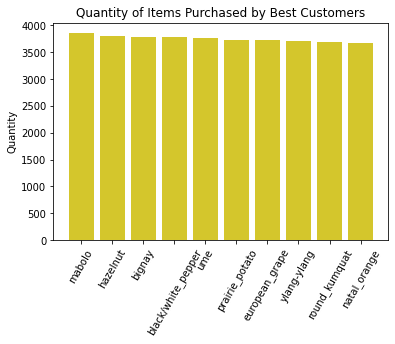

In [15]:
# Find out what items our best customers are purchasing and in what quantities
best_customer_purchases = valid_sales[valid_sales['customer_id'].isin(best_customers.index)].copy()
best_customer_product_purchases = pd.merge(best_customer_purchases, products_df, left_index=True, right_index=True)
best_customer_spending_habits = (best_customer_product_purchases.groupby('customer_id')
                                                                .sum()
                                                                .iloc[:, 2:]
                                                                .T)
                                                                
best_customer_spending_habits = (best_customer_spending_habits.reset_index().rename({'index': 'item'}, axis=1))
best_customer_spending_habits['total'] = best_customer_spending_habits.sum(axis=1)
best_customer_spending_habits.sort_values('total', ascending=False, inplace=True)

plt.bar(best_customer_spending_habits['item'], best_customer_spending_habits['total'], color=bc_color)
plt.title("Quantity of Items Purchased by Best Customers")
plt.xticks(rotation=60)
plt.ylabel('Quantity');

C:\Users\William\AppData\Local\Temp\ipykernel_29116\3421154024.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  remaining_customer_spending_habits['total'] = remaining_customer_spending_habits.sum(axis=1)


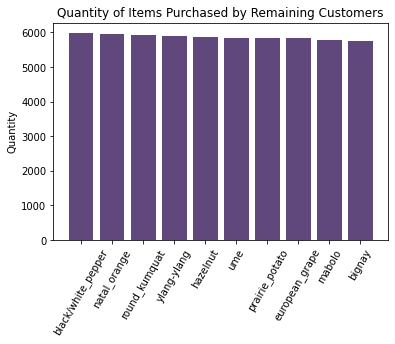

In [16]:
# Find out what items our customers are purchasing and in what quantities
remaining_customer_purchases = valid_sales[~valid_sales['customer_id'].isin(best_customers.index)].copy()
remaining_customer_product_purchases = pd.merge(remaining_customer_purchases, products_df, left_index=True, right_index=True)
remaining_customer_spending_habits = (remaining_customer_product_purchases.groupby('customer_id')
                                                                .sum()
                                                                .iloc[:, 2:]
                                                                .T)
                                                                
remaining_customer_spending_habits = (remaining_customer_spending_habits.reset_index().rename({'index': 'item'}, axis=1))
remaining_customer_spending_habits['total'] = remaining_customer_spending_habits.sum(axis=1)
remaining_customer_spending_habits.sort_values('total', ascending=False, inplace=True)

plt.bar(remaining_customer_spending_habits['item'], remaining_customer_spending_habits['total'], color=tc_color)
plt.title("Quantity of Items Purchased by Remaining Customers")
plt.xticks(rotation=60)
plt.ylabel('Quantity');

In [17]:
from mlxtend.frequent_patterns import apriori, association_rules

# Prep the data to be analyzed by the apyori python package
# by one-hot encoding (ohe) the purchases. If there is a 1 in
# the column, it means that item was purchased in the transaction.
ohe_purchases = (products_df.clip(upper=1)
                            .fillna(0)
                            .astype(int)
                            .copy())

# Accomplished wrt
# https://towardsdatascience.com/shop-order-analysis-in-python-ff13615404e0
# These are the most popular items purchased by customers, where natal oranges
# are the most popular items and umes are the least popular.
frequent_itemsets = apriori(ohe_purchases, min_support=0.05, use_colnames=True).sort_values(by=['support'], ascending=False)
frequent_itemsets

,support,itemsets
0,0.143275,(natal_orange)
5,0.142612,(black/white_pepper)
2,0.140593,(round_kumquat)
9,0.140171,(prairie_potato)
4,0.139358,(bignay)
6,0.138936,(mabolo)
3,0.138484,(ylang-ylang)
8,0.138152,(european_grape)
1,0.138002,(hazelnut)
7,0.136555,(ume)


In [18]:
# Interestingly, the apriori algorithm does not find any significant
# itemsets (items that are frequently purchased together). This tells me that each
# item has an equal liklihood of being selected by a customer. For instance, 
# given that a customer purchases a hazelnut they are no more likely to purchase a
# prairie potato than a european grape.
rules = association_rules(frequent_itemsets, metric='lift')
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [19]:
# To test and make sure that I am implementing this algorithm correctly,
# I followed the advice of the user in the link below who recommended to make 
# duplicate rows that would cause an obvious association between items.
# In this case, I chose to duplicate the transaction of a customer who purchased both
# ume and mabolo. We can see what an association would look like from the apriori algorithm
# in the dataframe under this cell.
# https://github.com/rasbt/mlxtend/issues/583
faked_association = pd.concat([ohe_purchases.iloc[33186].T]*10_000, axis=1).T.reset_index(drop=True)
faked_purchases = pd.concat([ohe_purchases, faked_association])
faked_frequent_itemsets = apriori(faked_purchases, min_support=0.05, use_colnames=True).sort_values(by=['support'], ascending=False)
association_rules(faked_frequent_itemsets, metric='lift')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(mabolo),(ume),0.338312,0.336482,0.252802,0.747245,2.220756,0.138966,2.625144
1,(ume),(mabolo),0.336482,0.338312,0.252802,0.751307,2.220756,0.138966,2.660669


Peak hour for sales value: 9


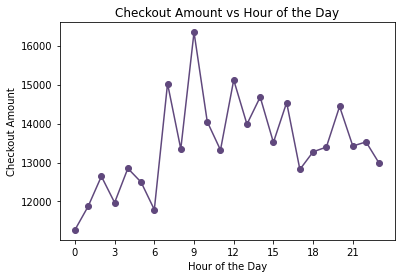

In [20]:
# Next, we will analyze when customers are likely to make their purchases
# based on the hour of the day.
valid_sales['hour'] = valid_sales.timestamp.dt.hour

# We will remove our best customers because whenever they decide
# to make a purchase will have an outsized affect on what is considered 
# peak checkout hours.
sales_by_hour = valid_sales[~valid_sales['customer_id'].isin(best_customers.index)].groupby('hour').sum()

# Plot sales by hour of the day
print(f"Peak hour for sales value: {sales_by_hour.checkout_amount.idxmax()}")
plt.plot(sales_by_hour.index, sales_by_hour.checkout_amount, color=tc_color)
plt.scatter(sales_by_hour.index, sales_by_hour.checkout_amount, color=tc_color)
plt.title('Checkout Amount vs Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Checkout Amount')
plt.xticks([hour for hour in range(0,24,3)]);

In [21]:
# From a quick glance at the shopping hours of our best customers,
# we can see that the majority of them enjoy shopping around noon.
valid_sales[valid_sales['customer_id'].isin(best_customers.index)]

,timestamp,date,time,website_id,customer_id,app_version,placeholder,checkout_amount,url,hour
4419,2017-07-01 12:44:11+00:00,2017-07-01,12:44:11,123,11613,1.1,NaN,55031.0,http://www.example.com/store/?Hazelnut=995&Ume...,12
5198,2017-07-01 14:14:34+00:00,2017-07-01,14:14:34,123,11611,1.1,NaN,8225.0,http://www.example.com/store/?Hazelnut=174&Ume...,14
5385,2017-07-01 14:33:54+00:00,2017-07-01,14:33:54,123,11613,1.1,NaN,55084.0,http://www.example.com/store/?Hazelnut=1015&Um...,14
9611,2017-07-01 23:23:12+00:00,2017-07-01,23:23:12,123,11612,1.1,NaN,8219.0,http://www.example.com/store/?Hazelnut=159&Ume...,23
14190,2017-07-02 08:57:09+00:00,2017-07-02,08:57:09,123,11611,1.1,NaN,8262.0,http://www.example.com/store/?Hazelnut=163&Ume...,8
15637,2017-07-02 11:50:23+00:00,2017-07-02,11:50:23,123,11611,1.1,NaN,8232.0,http://www.example.com/store/?Hazelnut=147&Ume...,11
16181,2017-07-02 13:02:41+00:00,2017-07-02,13:02:41,123,11613,1.1,NaN,55002.0,http://www.example.com/store/?Hazelnut=986&Ume...,13
22288,2017-07-03 01:44:26+00:00,2017-07-03,01:44:26,123,11612,1.1,NaN,8326.0,http://www.example.com/store/?Hazelnut=167&Ume...,1


Peak hour for sales traffic: 8


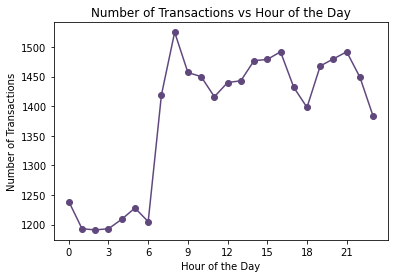

In [22]:
# Analyze when the sites experience the highest amount of traffic,
# found by determining when the most transactions are per hour
transactions_by_hour = valid_sales[~valid_sales['customer_id'].isin(best_customers.index)].groupby('hour').count()
print(f"Peak hour for sales traffic: {transactions_by_hour.timestamp.idxmax()}")
plt.plot(transactions_by_hour.index, transactions_by_hour.timestamp, color=tc_color)
plt.scatter(transactions_by_hour.index, transactions_by_hour.timestamp, color=tc_color)
plt.title('Number of Transactions vs Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Transactions')
plt.xticks([hour for hour in range(0,24,3)]);

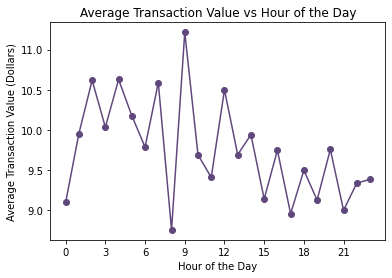

In [23]:
# Total checkout amount does not drop off as quickly as site traffic. This means
# that the fewer customers who do decide to make a purchase from 6 am - 12 am make
# larger purchases. The value per transaction per hour is plotted below.
average_transaction_value_by_hour = sales_by_hour.checkout_amount / transactions_by_hour.timestamp
plt.plot(average_transaction_value_by_hour.index, average_transaction_value_by_hour.values, color=tc_color)
plt.scatter(average_transaction_value_by_hour.index, average_transaction_value_by_hour.values, color=tc_color)
plt.title('Average Transaction Value vs Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Transaction Value (Dollars)')
plt.xticks([hour for hour in range(0,24,3)]);

In [24]:
# SIDE NOTE - websites changed versions at almost exactly the same time.
# The line of code below selects the very first instance where a customer
# uses the new version.
sales[sales['placeholder'].notna()].drop_duplicates('website_id')

,timestamp,date,time,website_id,customer_id,app_version,placeholder,checkout_amount,url,domain,products
23242,2017-07-03 03:42:11+00:00,2017-07-03,03:42:11,124,3338,1.2,new_version,5.0,http://xyz.com/checkout?Black%2FWhite+Pepper=1,xyz.com,black/white_pepper=1
23246,2017-07-03 03:42:42+00:00,2017-07-03,03:42:42,123,991,1.2,new_version,8.0,http://store.example.com/?Mabolo=1,store.example.com,mabolo=1


In [25]:
# Time when the error was encountered is seen below, just 4 hours
# after the new version of the app was launched on xyz.com
sales[sales['url'].str.contains('error')]

,timestamp,date,time,website_id,customer_id,app_version,placeholder,checkout_amount,url,domain,products
25418,2017-07-03 07:59:32+00:00,2017-07-03,07:59:32,124,8553,1.2,new_version,60000.0,http://xyz.com/checkout?Bignay=1&error=True,xyz.com,bignay=1&error=true


### Question 5
Predict the total sales number (in dollars) for 2017-07-04. Determine the certainty of this prediction. State explicitly what the prediction is doing, and what general steps you did to get the number you report and what assumptions you have made.

### Answer 5
This forecast was made using the Autoregressive Moving Average (ARMA) model from [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html). This model specifically uses ARMA(15,1) to predict that the total sales for July 4th (without outlier spenders like our best customers) will be **$108,025.29** +- \$27,120.69 at 95% confidence. This means that there is a 95% chance that even without the purchases of the best customers, the sales on July 4th will be between $80,904.60 and $135,145.97. This model likely underestimates the amount of spending that will occur on July 4th at 9 am (peak hours that were not captured by the moving average confidence interval during validation). Note that **this will be a dramatic underestimate if the best customers routinely purchase orders of magnitude more than other customers**.

Model Description

The [ARMA model](https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp) is a hybrid model of the [Autoregressive](https://online.stat.psu.edu/stat501/lesson/14/14.1) and [Moving Average](https://www.investopedia.com/terms/m/movingaverage.asp) models. 

- ARMA Model
    - $y = {\beta _0} + ({\beta _1} y_{t-1} + {\beta _2} y_{t-2} +...+ {\beta _p} y_{t-p}) + ({\epsilon _1} y_{t-1} + {\epsilon _2} y_{t-2} +...+ {\epsilon _q} y_{t-q}) + {\epsilon _{t}}$
        - ${\beta _0}$ - constant adjustment to the y-axis
        - ${\beta _p}$ - coefficents to determine the importance the pth timestep is in determining the current value
        - ${\epsilon _q}$ - coefficents to determine the importance the qth timestep's error in determining the current value
        - ${\epsilon _{t}}$ - Model error / Normally distributed random noise

In this specific case, the ARMA(15,1) model uses the difference between checkout amounts for the past 15 hours and the error of the last prediction to build a forecast of the value added to the store in future hours. Tuning this model involved adjusting 2 hyperparameters:
- p; Number of lag observations - (15 hours, solving for $p$ different $\beta$ coefficents)
- q; Size of moving average window - (1 hours, solving for $q$ different $\epsilon$ coefficents)

The ARMA model uses [autocorrelation and partial autocorrelation](https://www.youtube.com/watch?v=DeORzP0go5I) to solve for the $\beta$ and $\epsilon$ coefficents respectively.

Steps to Generate Model
- Outliers were removed from the dataset. Outliers were defined as transactions with checkout values greater than 3 standard deviations away from the mean.
- Transactions were grouped by the hour of the day they occurred and the checkout value was summed. This left the model with 72 data points to build the model. 
    - I could have chosen a smaller stepsize of say 5, 10, or 15 minute intervals to increase the number of data points used for training but this would require the model to accurately predict 12, 6, and 4 times as many future data points respectively. Therefore, I decided 60 minutes was a strong middle ground to optimize between data available for model creation and the number of points we would need to predict (24).
- The time series data was determined to be stationary using the Augmented Dickey-Fuller Test, leading me to choose the ARMA model over the ARIMA model / any other model with seasonality
- These 72 data points were split into a training set consisting of 85% of the dataset and a testing set consisting of the remaining 15% of the dataset. This left me with a maximum value of 61 for parameters $p$ and $q$ and a small testing set of 13 points to use to validate model performance at different parameters.
- The $p$ and $q$ parameters were adjusted to minimize the root mean squared error (RMSE) of the prediction for the remaining 13 hours. The optimal parameters were found to be p=15 and q=1 which generated a RMSE of 603.54. This means that each hour's prediction was off by an average of ~$600.
- This ARMA(15,1) model was applied to forecast the next 24 hours of data. The predicted sales for July 4th are the sum of all predicted sales across the model's predictions for these 24 hours. 

Assumptions
- The purchases of the best customers are rare. Until there is more data about these high-value customers, it is nearly impossible to build a model that predicts their behavior from their relatively low number of transactions.
- These three days of data preceeding a holiday are assumed to be a good representation of a typical day of transactions 
- The 4th of July holiday will not affect the sales on that day (Or, the spending habits preceeding the holiday are a good indicator of the spending behavior on a holiday)

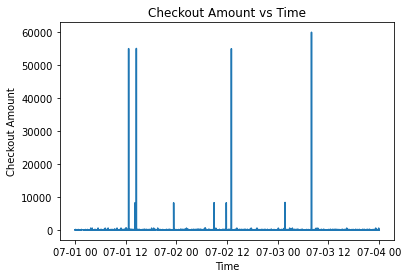

In [26]:
# First, let's take a look at the general trend of sales based on our timestamps
plt.plot(product_sales.timestamp, product_sales.checkout_amount)
plt.title('Checkout Amount vs Time')
plt.xlabel('Time')
plt.ylabel('Checkout Amount');

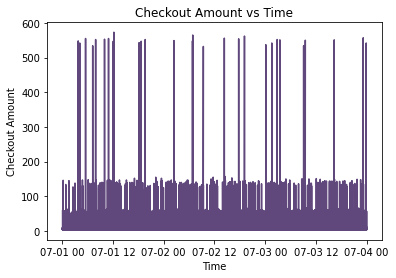

In [27]:
# The above graph is not very useful, as we are confronted with
# the disproportionate influence of our best customers. We will need to remove the 
# outliers here for our time series analysis (tsa). We can do this using the zscore
# (the number of standard deviations the checkout value is away from the mean).
# Accomplished wrt
# https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-a-pandas-dataframe
from scipy import stats

tsa = product_sales[product_sales['checkout_amount'] > 0].copy()
tsa = tsa[np.abs(stats.zscore(tsa['checkout_amount'])) < 3]

# Now we can plot the same graph without the outliers
plt.plot(tsa.timestamp, tsa.checkout_amount, color=tc_color)
plt.title('Checkout Amount vs Time')
plt.xlabel('Time')
plt.ylabel('Checkout Amount');

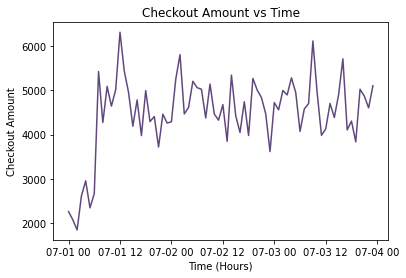

In [28]:
# The above graph indicates much more stable data (or rather, data
# without significant outliers). We can further clean this data
# by resampling the data to view the total checkout amount generated per hour
# Accomplished wrt
# https://towardsdatascience.com/how-to-group-data-by-different-time-intervals-using-python-pandas-eb7134f9b9b0
checkout_sum_by_hour = tsa.resample('H', on='timestamp').checkout_amount.sum()

plt.plot(checkout_sum_by_hour.index, checkout_sum_by_hour.values, color=tc_color)
plt.title('Checkout Amount vs Time')
plt.xlabel('Time (Hours)')
plt.ylabel('Checkout Amount');

In [29]:
# The above graph of sales per hour seems to indicate that the time series data is stationary. 
# This means that the data has a constant mean, standard deviation, and does not have seasonality
#
# The Augmented Dickey-Fuller Test uses Null Hypothesis Significance Testing
# to determine whether this assumption of stationarity is statistically significant.
# Accomplished wrt https://www.youtube.com/watch?v=1opjnegd_hA
from statsmodels.tsa.stattools import adfuller

t_stat, p_value, *_ = adfuller(checkout_sum_by_hour.values)
print(f"P value: {round(p_value, 8)}")
if p_value < 0.05:
    print(f"There is strong statistical evidence at alpha < 0.05 to suggest that this time series data is stationary.")
else:
    print(f"We fail to reject the null hypothesis that this time series data is not stationary")

C:\Users\William\Anaconda3\envs\postie\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


P value: 4.4e-07
There is strong statistical evidence at alpha < 0.05 to suggest that this time series data is stationary.


C:\Users\William\Anaconda3\envs\postie\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 603.54
Predicted total sales: $51,541.0
True total sales: $49,244.31
Difference in total sales: $2,296.6900000000023
Difference in total sales (pct): 4.66%


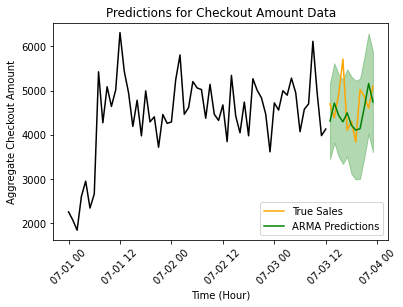

In [30]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# Since our data is stationary, it does NOT have seasonality. We can use the ARIMA model 
# (I stands for 'Integrated') with a value of 0 for the degree of differencing parameter to 
# create an ARMA model.
#
# Create a dataframe consisting of time series data we can use to forecast
forecast_data = (tsa.resample('H', on='timestamp')
                    .sum()['checkout_amount']
                    .copy()
                    .reset_index())
                    
# Remove UTC timezone designation and rename columns
forecast_data['timestamp'] = pd.to_datetime(forecast_data['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S'))
forecast_data.rename({'timestamp': 'ds', 'checkout_amount': 'y'}, axis=1, inplace=True)

# Separate this data into a training and testing set where 85% of the
# data will be used to train the model and 15% of the data will be used 
# to test the model
size = int(len(forecast_data)*0.85)
train, test = forecast_data.iloc[:size], forecast_data.iloc[size:]

# Implementation of ARIMA model accomplished wrt 
# https://builtin.com/data-science/time-series-forecasting-python
plt.plot(train.ds, train.y, color = "black")
plt.plot(test.ds, test.y, color = "orange", label = 'True Sales')
plt.ylabel('Aggregate Checkout Amount')
plt.xlabel('Time (Hour)')
plt.xticks(rotation=45)
plt.title("Predictions for Checkout Amount Data")

y_train = train['y']
ARMAmodel = ARIMA(y_train, order = (15, 0, 1))
ARMAmodel = ARMAmodel.fit()

y_pred = ARMAmodel.get_forecast(len(test.ds))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.ds
y_pred_out = y_pred_df["Predictions"] 

# Plot the prediction of the model,including the 95% confidence interval
# and the legend
plt.plot(y_pred_out, color='green', label = 'ARMA Predictions')
plt.fill_between(y_pred_df.index, y_pred_df['lower y'], y_pred_df['upper y'], 
                 edgecolor='g', facecolor='g', alpha=0.3)
plt.legend()

# Get the aggregate data for the forecasted prediction
true_total_sales = round(y_pred_df['Predictions'].sum(),2)
predicted_total_sales = round(test['y'].sum(),2)
pct_difference = (predicted_total_sales - true_total_sales) / true_total_sales

# Calculate the RMSE of the model compared to our test set
arma_rmse = np.sqrt(mean_squared_error(test["y"].values, y_pred_df["Predictions"]))
print(f"RMSE: {round(arma_rmse, 2)}")
print(f"Predicted total sales: ${predicted_total_sales:,}")
print(f"True total sales: ${true_total_sales:,}")
print(f"Difference in total sales: ${predicted_total_sales-true_total_sales:,}")
print(f"Difference in total sales (pct): {round(pct_difference*100,2):,}%")

Predicted sales for July 4th: $108,025.29 +- $27,120.689999999988 at 95% confidence
Minimum predicted sales for July 4th: $80,904.6
Maximum predicted sales for July 4th: $135,145.97


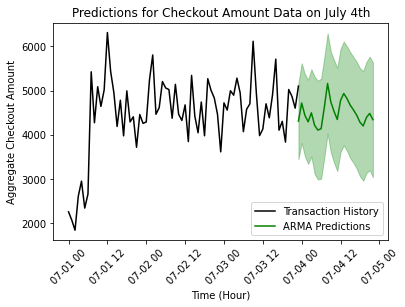

In [31]:
from datetime import timedelta

# Extend the timestamp from the end of the test set to the end of July 4th
last_date = test.iloc[0].ds
next_day_hours = [test.iloc[-1].ds + timedelta(hours=hour) for hour in range(0, 24)]

# Use this model to predict the sales for the next 24 hours
y_pred = ARMAmodel.get_forecast(24)
# Create a 95% confidence interval of possible sales values per hour
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = next_day_hours
y_pred_out = y_pred_df["Predictions"]

# Plot the known data from our transactions
plt.plot(forecast_data.ds, forecast_data.y, color = "black", label = 'Transaction History')
plt.ylabel('Aggregate Checkout Amount')
plt.xlabel('Time (Hour)')
plt.xticks(rotation=45)
plt.title("Predictions for Checkout Amount Data on July 4th")

# Plot the prediction of the model for July 4th including the 95% confidence interval
plt.plot(y_pred_out, color='green', label = 'ARMA Predictions')
plt.fill_between(y_pred_df.index, y_pred_df['lower y'], y_pred_df['upper y'], 
                 edgecolor='g', facecolor='g', alpha=0.3)
plt.legend()

# Explicity state the confidence interval of the lower and upper bounds of this model at 95% confidence.
# This means that the model believes there is a 95% chance that the true sales (excluding outlier
# customers) will be between the predicted amount plus or minus the confidence interval (CI)
CI = round(y_pred_df['Predictions'].sum(),2) - round(y_pred_df['lower y'].sum(),2)

print(f"Predicted sales for July 4th: ${round(y_pred_df['Predictions'].sum(),2):,}", f"+- ${CI:,} at 95% confidence")
print(f"Minimum predicted sales for July 4th: ${round(y_pred_df['lower y'].sum(),2):,}")
print(f"Maximum predicted sales for July 4th: ${round(y_pred_df['upper y'].sum(),2):,}")

### Question 6
State what additional information, data or access would make your prediction better.

### Answer 6
More data would be needed to make a more accurate model. In this case, we only have 72 hours worth of data and are expected to predict the next 24 hours. There is a high probability that this model is overfit to this data. This model also excludes the use of outlier spenders like the best customers. Data about the spending habits of those best customers (such as whether they make their purchases on a weekly, monthly, or yearly basis) would be extremely valuable to the model. 

Customer behavior on July 4th is also likely to be affected by the fact that it is an American holiday (assuming that the customers are American or celebrate the 4th of July). Additionally, July 1st, 2017 was a Saturday. This means that this dataset only includes customer behavior on the weekend (Saturday, Sunday, and Monday) preceeding a holiday. I would also imagine that customer behavior changes during the work week from Monday-Friday, but that could be a completely incorrect assumption. The following information would be useful to construct a more rigirous model:
- More days of transaction data
- How frequently the best customers (outliers that were removed from the model) make their large purchases at the store
- Customer transactions on weekdays
- Customer transactions on weekends that preceed other holidays
- Customer transactions on weekends that do not preceed holidays
- Customer transactions on holidays (July 4th is an American holiday, sales prices are likely to vary if the customers are American)
- Customer nationality
- The duration of any ad campaigns or events designed to bring more customers to the site 
- Dates when items are restocked (customers might be attracted to fresher products)

### Conclusion - Pushing work to [GitHub](https://github.com/williamrhayes/postie-data-challenge)

From CLI:

> git init postie-data-challenge

> git add -A

> git commit -m "postie data challenge"

> git remote add origin https://github.com/williamrhayes/postie-data-challenge.git

> git push -u origin master

# Workspace

Notes:
- There are two different UTC designations: +00:00 and -07:00. This might mean that the customers are from the midwestern United States (+00:00) and the UK (-07:00).
- It looks like example.com changed versions. in v1.1 the user checks out at www.example.com. In version 1.2 the user checks out at store.example.com. I can tell that these are both the same website because they have the same website_id
- URL Encodings of various different characters are listed [here](https://www.w3schools.com/tags/ref_urlencode.asp). I noticed %2F which likely indicates a '/' in the product "Black%2FWhite+Pepper"  =  "Black/White Pepper"
- On July 3rd, the new versions of both apps were released. For customer id 8553, this caused an issue where they were charged $60k for bignay

Points of Interest
- [DONE] Multiple linear equations to solve for product prices
- [DONE] xyz.com encountered an error on the new platform v1.2. The first transaction caused an issue where customer id 8553 was charged $60k for a bignay. Subsequent transactions did not cause issues (no other "error" strings in urls).
- [DONE] Sometimes the checkout amount is 0 or negative for some reason
- [DONE] Best times for transactions
- [DONE] Best times for value